In [1]:
# pip install GOFevaluation
# pip install goodness-of-fit
# pip install torchinfo
# pip install netron
# pip install onnx
# pip install onnxscript

Import packages.

In [2]:
# %env LD_LIBRARY_PATH=/usr/lib/wsl/lib/
# %env NUMBA_CUDA_DRIVER=
# %env LD_LIBRARY_PATH=
# %env NUMBA_CUDA_DRIVER=/usr/lib/wsl/lib/libcuda.so.1
# %env CUDA_HOME=/home/yifeng/miniconda3/envs/attention/lib/python3.12/site-packages/nvidia/cuda_runtime
# Setting LD_LIBRARY_PATH in Jupyter Notebook using %env magic
# %env LD_LIBRARY_PATH=/home/yifeng/miniconda3/envs/attention/lib/python3.12/site-packages/nvidia/cuda_nvrtc/lib/

# %load_ext cudf.pandas

import torch
import torchvision.transforms as transforms
from torchvision import models
import torchvision
import torch.nn as nn
from PIL import Image
from torchinfo import summary
import onnx
import netron

# import GOFevaluation as ge
# from goodness_of_fit import gof_measure
from goodness_of_fit_cupy import gof_measure
import numpy as np
import cupy as cp
# import cupy_backends.cuda.libs._cuda_deps
import scipy.stats as sps
import pandas as pd

Defined download folder for pre-trained models.

In [3]:
import os

# Construct the path to the 'model' folder within your project directory
model_dir = os.path.join(os.getcwd(), 'models')

# Set the TORCH_HOME environment variable to the 'model' directory path
os.environ['TORCH_HOME'] = model_dir

# Load the pretrained model and observe its structure.

In [4]:
# Load the Pre-trained ResNet-50 Model
model = torchvision.models.resnet50(pretrained=True)

/home/yifeng/miniconda3/envs/cupy/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yifeng/miniconda3/envs/cupy/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Resnet-50 structure:

![Different ResNet Architecture](https://miro.medium.com/v2/resize:fit:700/1*IP9PgUQmkhJiFRdIW6TwMQ.png)

The bottleneck of TorchVision places the stride for downsampling to the second 3x3 convolution while the original paper places it to the first 1x1 convolution. This variant improves the accuracy and is known as ResNet V1.5. See:
[Pytorch pre-trained resnet-50](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html)

![Resnet-50-1](https://www.researchgate.net/profile/Anastasios-Stamoulakatos/publication/338833936/figure/fig3/AS:851920512110592@1580125086957/ResNet-50-architecture-with-modified-head.png)

In [5]:
# Iterate over all modules, including nested ones
for name, _ in model.named_modules():
    print(name)


conv1
bn1
relu
maxpool
layer1
layer1.0
layer1.0.conv1
layer1.0.bn1
layer1.0.conv2
layer1.0.bn2
layer1.0.conv3
layer1.0.bn3
layer1.0.relu
layer1.0.downsample
layer1.0.downsample.0
layer1.0.downsample.1
layer1.1
layer1.1.conv1
layer1.1.bn1
layer1.1.conv2
layer1.1.bn2
layer1.1.conv3
layer1.1.bn3
layer1.1.relu
layer1.2
layer1.2.conv1
layer1.2.bn1
layer1.2.conv2
layer1.2.bn2
layer1.2.conv3
layer1.2.bn3
layer1.2.relu
layer2
layer2.0
layer2.0.conv1
layer2.0.bn1
layer2.0.conv2
layer2.0.bn2
layer2.0.conv3
layer2.0.bn3
layer2.0.relu
layer2.0.downsample
layer2.0.downsample.0
layer2.0.downsample.1
layer2.1
layer2.1.conv1
layer2.1.bn1
layer2.1.conv2
layer2.1.bn2
layer2.1.conv3
layer2.1.bn3
layer2.1.relu
layer2.2
layer2.2.conv1
layer2.2.bn1
layer2.2.conv2
layer2.2.bn2
layer2.2.conv3
layer2.2.bn3
layer2.2.relu
layer2.3
layer2.3.conv1
layer2.3.bn1
layer2.3.conv2
layer2.3.bn2
layer2.3.conv3
layer2.3.bn3
layer2.3.relu
layer3
layer3.0
layer3.0.conv1
layer3.0.bn1
layer3.0.conv2
layer3.0.bn2
layer3.0.conv

Check the loaded pre-trained model.

In [6]:
summary(model, (1, 3, 224, 224), depth=3)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│ 

In [7]:
torch_input = torch.randn(1, 3, 224, 224)

In [8]:
model = model.cuda()  # Move the model to CUDA
torch_input = torch_input.cuda()  # Move the input tensor to CUDA

In [9]:
# onnx_program = torch.onnx.dynamo_export(model, torch_input)
onnx_path = "./models/resnet50_pretrained.onnx"
# onnx_program.save(onnx_path)
torch.onnx.export(model, torch_input, onnx_path)

In [10]:
# onnx_model = onnx.load(onnx_path)
# onnx.checker.check_model(onnx_model)

# visualize the model structure using netron
netron.start(onnx_path)

Serving './models/resnet50_pretrained.onnx' at http://localhost:8080


('localhost', 8080)

gio: http://localhost:8080: Operation not supported


In [11]:
# stop visualization server
netron.stop()

Stopping http://localhost:8080


1. Load and Transform the CIFAR-10 Dataset

In [12]:
def data_loading(dataset, dataset_path, mean, std, num_samples=100):
    transform = transforms.Compose([
        transforms.Resize(224),  # Resize images to 224x224
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ])

    if dataset == "CIFAR-10":
        # Load CIFAR-10
        trainset = torchvision.datasets.CIFAR10(root=dataset_path, train=True,
                                                download=True, transform=transform)

        testset = torchvision.datasets.CIFAR10(root=dataset_path, train=False,
                                               download=True, transform=transform)
    elif dataset == "CIFAR-100":
        # Load CIFAR-10
        trainset = torchvision.datasets.CIFAR100(root=dataset_path, train=True,
                                                 download=True, transform=transform)

        testset = torchvision.datasets.CIFAR100(root=dataset_path, train=False,
                                                download=True, transform=transform)
    else:
        return "Invaid Dataset."
    # Concatenate the training and testing datasets
    combined_set = torch.utils.data.ConcatDataset([trainset, testset])

    # Generate random indices to sample from the dataset
    indices = np.random.choice(len(combined_set), num_samples, replace=False)

    # Create a subset based on the generated indices
    sampled_subset = torch.utils.data.Subset(combined_set, indices)

    # Create a single DataLoader from the combined dataset
    loader = torch.utils.data.DataLoader(sampled_subset, batch_size=1, shuffle=True)

    return loader

## Normalize the image pixel values based on the mean and standard deviation of the ImageNet dataset across the RGB channels. 
The purpose of this normalization is to transform the input images so that their pixel value distribution more closely resembles that of the original ImageNet training data. By doing this, we put CIFAR-10 images on a similar scale and distribution as the ImageNet images, which can help the pre-trained model make better predictions or extract more relevant features from the CIFAR-10 images.

In [13]:
# mean and standard deviation of the ImageNet dataset across the RGB channels
# mean = [0.485, 0.456, 0.406]
# std = [0.229, 0.224, 0.225]
mean = [0.4914, 0.4822, 0.4465]
std = [0.247, 0.243, 0.261]
dataset = "CIFAR-10"
num_samples = 100
# Define custom path for the CIFAR dataset
dataset_path = '../datasets/CIFAR/'

In [14]:
loader = data_loading(dataset, dataset_path, mean, std, num_samples)

Files already downloaded and verified
Files already downloaded and verified


In [15]:
def modify_fclayer(dataset, model):
    if dataset == "CIFAR-10":
        # Modify the ResNet-50 Model for CIFAR
        num_ftrs = model.fc.in_features  # Get the number of features in the last layer
        model.fc = nn.Linear(num_ftrs, 10)  # Replace the last layer

    elif dataset == "CIFAR-100":
        # Modify the ResNet-50 Model for CIFAR
        num_ftrs = model.fc.in_features  # Get the number of features in the last layer
        model.fc = nn.Linear(num_ftrs, 100)  # Replace the last layer

    return model

In [16]:
model = modify_fclayer(dataset, model)

In [17]:
model.eval()  # Set the model to evaluation mode

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Define selected layers

In [18]:
# selected_layer_names =[
#     'layer1.0.conv2','layer1.1.conv2','layer1.2.conv2',
#     'layer2.0.conv2','layer2.1.conv2','layer2.2.conv2','layer2.3.conv2',
#     'layer3.0.conv2','layer3.1.conv2','layer3.2.conv2','layer3.3.conv2','layer3.4.conv2','layer3.5.conv2',
#     'layer4.0.conv2','layer4.1.conv2','layer4.2.conv2'
# ]

selected_layer_names = [
    'layer1.0.relu', 'layer1.1.relu', 'layer1.2.relu',
    'layer2.0.relu', 'layer2.1.relu', 'layer2.2.relu', 'layer2.3.relu',
    'layer3.0.relu', 'layer3.1.relu', 'layer3.2.relu', 'layer3.3.relu', 'layer3.4.relu', 'layer3.5.relu',
    'layer4.0.relu', 'layer4.1.relu', 'layer4.2.relu'
]

layer_names_for_saving = [
    'Bottleneck2-1', 'Bottleneck2-2', 'Bottleneck2-3',
    'Bottleneck3-1', 'Bottleneck3-2', 'Bottleneck3-3', 'Bottleneck3-4',
    'Bottleneck4-1', 'Bottleneck4-2', 'Bottleneck4-3', 'Bottleneck4-4', 'Bottleneck4-5', 'Bottleneck4-6',
    'Bottleneck5-1', 'Bottleneck5-2', 'Bottleneck5-3'
]

In [19]:
def select_layers(model, selected_layer_names):
    selected_layers = []
    # Iterate over all modules
    for name, module in model.named_modules():
        if name in selected_layer_names:
            selected_layers.append(module)

    return selected_layers

In [20]:
# selected_layers=select_layers(model,selected_layer_names)

## Define goodness-of-fit metrics

In [21]:
sample_gof_list = [
    # 'ADTestTwoSampleGOF',
    # 'KSTestTwoSampleGOF',
    # 'PointToPointGOF',
]

binned_gof_list = [
    # 'KSTestGOF',  # need bin edges
    # 'BinnedPoissonChi2GOF', # need pdf
    # 'BinnedChi2GOF'   # need pdf
]

Define PDF types

In [22]:
pdf_type = {
    'gaussian': sps.norm.rvs,
    'laplace': sps.laplace.rvs,
}

PDF resample function

In [23]:
def resample_and_bin(data, pdf_type, bins=10):
    # Flatten the N-D array to 1-D
    data_flattened = data.ravel()

    # Calculate mean and standard deviation using CuPy
    mean = cp.mean(data_flattened).get()  # Use .get() to transfer the result to CPU as a NumPy scalar
    std = cp.std(data_flattened).get()  # Use .get() to transfer the result to CPU as a NumPy scalar

    outputs = {}
    for dist_name, dist_func in pdf_type.items():
        # Fit and resample from the specified distribution
        if dist_name == 'gaussian':
            samples = dist_func(loc=mean, scale=std, size=len(data_flattened), random_state=42)
        elif dist_name == 'laplace':
            # Scale parameter for Laplace is std / sqrt(2) according to the definition
            samples = dist_func(loc=mean, scale=std / np.sqrt(2), size=len(data_flattened), random_state=42)
        else:
            raise ValueError(f"Unsupported distribution: {dist_name}")

        # Transfer samples to GPU for further processing
        samples_gpu = cp.asarray(samples)  # Transfer samples array to GPU

        # Bin the data from the current distribution and capture the bin edges
        binned, bin_edges = cp.histogram(samples_gpu, bins=bins, density=True)

        # Store the sampled array, its binned version, and the bin edges in the outputs dictionary
        outputs[dist_name] = {'samples': samples_gpu, 'binned': binned, 'bin_edges': bin_edges}

    # Output the dictionary containing sampled arrays and their binned versions for all distributions
    return outputs

Calculate goodness-of-fit scores on one channel

In [24]:
def gof_calculation(sample_gof_list, binned_gof_list, data, reference):
    gof_scores = {}

    # Iterate through each pdf_name in the reference
    # for pdf_name in reference.keys():
    #     # Calculate sample-based GOF for 'samples'
    #     if 'samples' in reference[pdf_name]:
    #         samples = reference[pdf_name]['samples']
    #         gof_object = ge.GOFTest(data_sample=data, reference_sample=samples, gof_list=sample_gof_list)  # Using data as both sample and reference
    #         gofs=gof_object.get_gofs(d_min=0.01)  # Adjust d_min based on your requirement
    #         for gof_name in sample_gof_list:
    #             # Concatenate pdf_name with gof_name for the key
    #             new_key_name = f"{pdf_name}_{gof_name}"
    #             gof_scores[new_key_name] = gofs[gof_name]

    #     # Calculate binned-based GOF for 'binned'
    #     if 'binned' in reference[pdf_name]:
    #         samples_binned = reference[pdf_name]['binned']
    #         bin_edges = reference[pdf_name]['bin_edges']
    #         # Handle "KSTestGOF" separately
    #         if 'KSTestGOF' in binned_gof_list:
    #             gof_object_ks = ge.KSTestGOF(data, samples_binned,bin_edges)
    #             gof_ks = gof_object_ks.get_gof()
    #             new_key_name_ks = f"{pdf_name}_KSTestGOF_binned"
    #             gof_scores[new_key_name_ks] = gof_ks

    #        # Prepare a list excluding "KSTestGOF" for the remaining calculations
    #         other_binned_gof_list = [gof_name for gof_name in binned_gof_list if gof_name != 'KSTestGOF']

    #         # Proceed with the remaining binned GOF measures
    #         if other_binned_gof_list:
    #             gof_object_binned = ge.GOFTest(data_sample=data, reference_sample=samples_binned, gof_list=other_binned_gof_list)
    #             gofs = gof_object_binned.get_gofs(d_min=0.01)  # Adjust d_min based on your requirement
    #             for gof_name in other_binned_gof_list:
    #                 # Concatenate pdf_name with gof_name for the key
    #                 new_key_name = f"{pdf_name}_{gof_name}_binned"
    #                 gof_scores[new_key_name] = gofs[gof_name]

    # GOF measures based on the goodness_of_fit package
    for gof_name, gof_func in gof_measure.items():
        for pdf_name in reference.keys():
            if 'samples' in reference[pdf_name]:
                samples = reference[pdf_name]['samples']
                # Concatenate pdf_name with gof_name for the key
                new_key_name = f"{pdf_name}_{gof_name}"
                gof_scores[new_key_name] = gof_func(samples, data)
                # print(f"{new_key_name}: {gof_scores[new_key_name]}")

    return gof_scores

Calculate gof scores of one feature map

In [25]:
def feature_map_gof_calculation(feature_map, pdf_tpye, sample_gof_list, binned_gof_list):
    """
    Calculate GOF scores for each channel in a feature map and average the scores.

    :param feature_map: A numpy array of shape (C,H,W) representing the feature map.
    :param sample_gof_list: A list of sample-based GOF measures.
    :param binned_gof_list: A list of binned-based GOF measures.
    :param gof_measure: A dictionary of other GOF measures.
    :return: A dictionary of averaged GOF scores.
    """
    # W, H, C = feature_map.shape
    C, H, W = feature_map.shape
    gof_scores_sum = {}

    valid_channels = 0  # Counter for valid channels

    # Threshold to define low variance
    variance_threshold = 1e-6

    # Iterate through each channel
    for c in range(C):
        # Reshape W*H samples into a 1D array for the current channel
        epsilon = 1e-8  # small value
        data_sample = feature_map[c, :, :].reshape(-1) + epsilon
        # data_sample = feature_map[:, :, c].reshape(-1)
        # data_sample = data_sample[data_sample != 0]
        if cp.var(data_sample) < variance_threshold:
            print(f"Channel {c} has low variance, skipping.")
            continue

        # Assuming 'reference' contains predefined distributions for GOF comparison
        # Here 'reference' needs to be defined or passed to the function based on your setup
        reference = resample_and_bin(data_sample, pdf_tpye, 30)

        # Calculate GOF scores for the current channel
        gof_scores_channel = gof_calculation(sample_gof_list, binned_gof_list, data_sample, reference)

        if any(cp.isnan(score) for score in gof_scores_channel.values()):
            print(f"Channel {c} returned NaN for GOF metrics, skipping.")
            continue

        valid_channels += 1
        # Sum the GOF scores for averaging later
        for gof_name, score in gof_scores_channel.items():
            score_cpu = float(cp.asnumpy(score)) if isinstance(score, cp.ndarray) else float(score)
            if gof_name not in gof_scores_sum:
                gof_scores_sum[gof_name] = 0
            gof_scores_sum[gof_name] += score_cpu

    # Calculate the average GOF score across all channels
    gof_scores_avg = {gof_name: score / valid_channels for gof_name, score in gof_scores_sum.items()}

    return gof_scores_avg

Extract feature maps according to the selected layer names.

In [26]:
def extract_feature_maps(model, selected_layer_names, input_image, relu_invocations):
    feature_maps = {}

    def hook_fn(module, input, output):
        # Find the layer's name in the model by matching the module object
        for name, mod in model.named_modules():
            if mod == module:
                # feature_maps[name] = output.detach()
                # Increase the count of ReLU invocations
                relu_invocations[name] += 1
                # print(f"Layer: {name}, ReLU invocations: {relu_invocations[name]}")

                # Store the output only for the first ReLU invocation (residual branch)
                if relu_invocations[name] == 1 or relu_invocations[name] == 2:
                    feature_maps[name] = output.detach()
                break

    hooks = []
    # Register hooks using the layer names
    for name, module in model.named_modules():
        # print(name)
        if name in selected_layer_names:
            # print('find')
            hook = module.register_forward_hook(hook_fn)
            hooks.append(hook)

    # Forward pass to extract feature maps
    model(input_image)

    # Remove hooks
    for hook in hooks:
        hook.remove()

    return feature_maps

Calculate the gof scores on all feature maps.

In [27]:
def compute_gof_scores(feature_maps, pdf_type, sample_gof_list, binned_gof_list, selected_layer_names, layer_names_for_saving):
    # Initialize an empty DataFrame for all scores
    all_scores_df = pd.DataFrame()

    for layer_name, fmap in feature_maps.items():
        # Squeeze batch dimension if necessary (assuming the batch size is always 1)
        if fmap.dim() > 3:
            fmap = fmap.squeeze(0)

        # Now fmap should be in the format of C x H x W, so we can get the number of channels directly
        num_channels = fmap.size(0)  # The number of channels is the size of the first dimension

        print(f"Layer: {layer_name}, Number of Channels: {num_channels}")

    for layer_name, fmap in feature_maps.items():
        # fmap is a PyTorch tensor on the GPU
        fmap = fmap.squeeze(0)
        # Convert directly to a CuPy array, keeping the data on the GPU
        fmap_gpu_array = cp.asarray(fmap)
        # Calculate GOF scores for the feature map
        fmap_scores = feature_map_gof_calculation(fmap_gpu_array, pdf_type, sample_gof_list, binned_gof_list)
        # Convert the fmap_scores dictionary into a DataFrame
        # 'gof_scores' as index and one column named 'score' with the GOF scores
        fmap_df = pd.DataFrame(list(fmap_scores.items()), columns=['gof_scores', 'score'])
        # print(fmap_df)

        # Map the layer name to the corresponding descriptive name for saving
        layer_index = selected_layer_names.index(layer_name)
        descriptive_layer_name = layer_names_for_saving[layer_index]

        # Rename the 'score' column to the descriptive layer name
        fmap_df.rename(columns={'score': descriptive_layer_name}, inplace=True)

        # If this is the first layer, initialize all_scores_df with fmap_df
        if all_scores_df.empty:
            all_scores_df = fmap_df
        else:
            # Merge the current fmap_df with all_scores_df on the 'gof_scores' column
            # This aligns the scores for the same GOF metrics across different layers
            all_scores_df = pd.merge(all_scores_df, fmap_df, on='gof_scores', how='outer')

    return all_scores_df

Calculate gof scores on all sampled data.

In [28]:
def calculate_gof_scores_for_dataloader(model, loader, selected_layer_names, pdf_type, sample_gof_list, binned_gof_list, layer_names_for_saving):
    """
    Calculate GOF scores for each image in the DataLoader, for selected layers of the model.

    :param model: The neural network model.
    :param loader: The DataLoader containing the dataset.
    :param selected_layers: The selected layers of the model for which to calculate GOF scores.
    :param pdf_type: The PDF types used for resampling.
    :param sample_gof_list: A list of sample-based GOF measures.
    :param binned_gof_list: A list of binned-based GOF measures.
    :param layer_names_for_saving: The layer names corresponding to the selected layers, used for saving in DataFrame.
    :return: A DataFrame with averaged GOF scores across all images in the DataLoader.
    """
    total_df = pd.DataFrame()
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    device = torch.device("cuda")
    model.to(device)

    # Iterate over the DataLoader
    for i, (input_images, _) in enumerate(loader):
        input_images = input_images.to(device)
        print(f"Processing batch {i+1}/{len(loader)}...")

        for j, input_image in enumerate(input_images):
            input_image = input_image.unsqueeze(0)  # Add batch dimension if necessary
            input_image = input_image.to(device)  # Move to the same device as the model

            # Initialize relu_invocations for the current image
            relu_invocations = {name: 0 for name in selected_layer_names}

            # Extract feature maps for the current image
            feature_maps = extract_feature_maps(model, selected_layer_names, input_image, relu_invocations)

            # print(len(feature_maps))

            # Compute GOF scores for the extracted feature maps
            scores_df = compute_gof_scores(feature_maps, pdf_type, sample_gof_list, binned_gof_list, selected_layer_names, layer_names_for_saving)
            # print("scores df:")
            # print(scores_df)
            # Sum the scores across all processed images for averaging later
            if total_df.empty:
                total_df = scores_df
            else:
                # Sum corresponding scores
                for col in layer_names_for_saving:
                    total_df[col] += scores_df[col]
    # print("total df:")
    # print(total_df)
    # Compute the average scores by dividing the summed scores by the number of processed images
    total_df[layer_names_for_saving] = total_df[layer_names_for_saving].div(len(loader.dataset))
    # print("average df:")
    # print(total_df)

    # Compute the overall score by averaging across layers for each GOF metric after summing
    for gof_name in total_df['gof_scores'].unique():
        total_df.loc[total_df['gof_scores'] == gof_name, 'overall'] = total_df[total_df['gof_scores'] == gof_name][layer_names_for_saving].mean(axis=1)

    return total_df

In [29]:
total_average_df = calculate_gof_scores_for_dataloader(model, loader, selected_layer_names, pdf_type, sample_gof_list, binned_gof_list, layer_names_for_saving)

Processing batch 1/100...
Layer: layer1.0.relu, Number of Channels: 64
Layer: layer1.1.relu, Number of Channels: 64
Layer: layer1.2.relu, Number of Channels: 64
Layer: layer2.0.relu, Number of Channels: 128
Layer: layer2.1.relu, Number of Channels: 128
Layer: layer2.2.relu, Number of Channels: 128
Layer: layer2.3.relu, Number of Channels: 128
Layer: layer3.0.relu, Number of Channels: 256
Layer: layer3.1.relu, Number of Channels: 256
Layer: layer3.2.relu, Number of Channels: 256
Layer: layer3.3.relu, Number of Channels: 256
Layer: layer3.4.relu, Number of Channels: 256
Layer: layer3.5.relu, Number of Channels: 256
Layer: layer4.0.relu, Number of Channels: 512
Layer: layer4.1.relu, Number of Channels: 512
Layer: layer4.2.relu, Number of Channels: 512
Channel 0 has low variance, skipping.
Channel 19 has low variance, skipping.
Channel 59 has low variance, skipping.
Channel 61 has low variance, skipping.
Channel 40 has low variance, skipping.
Channel 43 has low variance, skipping.
Channel 

Manipulate dataframe for friendly reading before saving.

In [30]:
# Function to extract metric name and distribution from the row name
def extract_metric_and_dist(row_name):
    parts = row_name.split('_')
    dist = parts[0]  # e.g., "gaussian" or "laplace"
    metric = '_'.join(parts[1:])  # e.g., "ADTestTwoSampleGOF"
    return metric, dist

# Custom sort key that prioritizes the metric name and then the distribution name


def custom_sort_key(row_name):
    metric, dist = extract_metric_and_dist(row_name)
    return (metric, dist)


# Ensure 'gof_scores' is set as the index if it's not already
if total_average_df.index.name != 'gof_scores':
    total_average_df = total_average_df.set_index('gof_scores')

# Sort the DataFrame using the custom sort key
sorted_index = sorted(total_average_df.index, key=custom_sort_key)
sorted_df = total_average_df.loc[sorted_index]

# Optionally, if you want to reset the index to make 'gof_scores' a column again
sorted_df = sorted_df.reset_index()

In [31]:
sorted_df.head()

,gof_scores,Bottleneck2-1,Bottleneck2-2,Bottleneck2-3,Bottleneck3-1,Bottleneck3-2,Bottleneck3-3,Bottleneck3-4,Bottleneck4-1,Bottleneck4-2,Bottleneck4-3,Bottleneck4-4,Bottleneck4-5,Bottleneck4-6,Bottleneck5-1,Bottleneck5-2,Bottleneck5-3,overall
0,gaussian_DG,-0.975054,-0.983453,-0.974633,-0.976005,-0.970981,-0.971770,-0.973072,-0.877419,-0.878791,-0.873584,-0.877832,-0.875702,-0.891763,-0.808928,-0.820630,-0.875222,-0.912802
1,laplace_DG,-1.013111,-1.018270,-1.014716,-0.940649,-0.944016,-0.953147,-0.950503,-0.876633,-0.885891,-0.888406,-0.892443,-0.887693,-0.892680,-0.853925,-0.846939,-0.862913,-0.920121
2,gaussian_KGE,-0.001621,-0.008851,-0.001303,-0.001498,0.000517,0.000063,-0.000029,-0.007074,-0.011650,-0.006080,-0.008538,-0.008581,-0.018376,-0.058953,-0.117310,-0.152001,-0.025081
3,laplace_KGE,-0.000437,-0.003238,-0.001221,0.005194,0.003077,-0.001643,0.000133,-0.000060,-0.021977,-0.011108,-0.014104,-0.016887,-0.024922,-0.049135,-0.068678,-0.080794,-0.017863
4,gaussian_NSE,-0.975054,-0.983453,-0.974633,-0.976005,-0.970981,-0.971770,-0.973072,-0.877419,-0.878791,-0.873584,-0.877832,-0.875702,-0.891763,-0.808928,-0.820630,-0.875222,-0.912802


In [32]:
result_path = f'./result/{dataset}/total_average_scores.csv'
os.makedirs(os.path.dirname(result_path), exist_ok=True)
sorted_df.to_csv(result_path, index=False)

Plot all scores.

In [33]:
import matplotlib.pyplot as plt


def plot_metrics(sorted_df, dataset_name):
    # Number of subplots to create
    num_plots = len(sorted_df) // 2

    # Setting up the figure and subplots
    fig, axs = plt.subplots(num_plots, 1, figsize=(10, 5 * num_plots))

    # If there's only one plot, axs may not be an array, so we wrap it in a list for consistency
    if num_plots == 1:
        axs = [axs]

    # Iterate through every 2 rows
    for i in range(0, len(sorted_df), 2):
        row1, row2 = sorted_df.iloc[i], sorted_df.iloc[i+1]
        metric_name = row1['gof_scores'].split('_')[1]  # Assuming metric name is after the first underscore

        # Plotting the two rows as lines on the subplot
        axs[i//2].plot(sorted_df.columns[1:], row1[1:], label=row1['gof_scores'])  # Skip the 'gof_scores' column
        axs[i//2].plot(sorted_df.columns[1:], row2[1:], label=row2['gof_scores'])  # Skip the 'gof_scores' column

        # Setting x-axis labels to column names
        axs[i//2].set_xticks(range(len(sorted_df.columns[1:])))
        axs[i//2].set_xticklabels(sorted_df.columns[1:], rotation=45, ha="right")

        # Setting the subplot title
        axs[i//2].set_title(f"{dataset_name} {metric_name}")

        # Adding a legend to distinguish the two lines
        axs[i//2].legend()

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plot
    plt.show()

    # Save the plot to a file
    fig.savefig(f'./result/{dataset_name}/metrics_comparison.png')

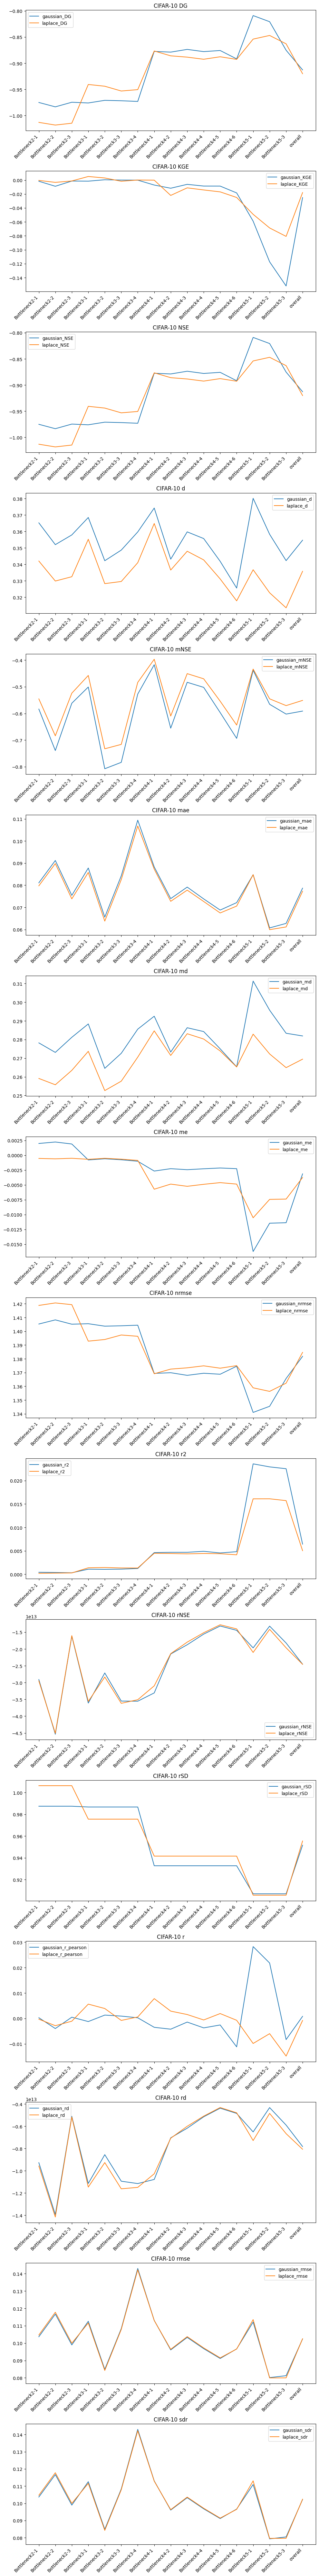

In [34]:
plot_metrics(sorted_df, dataset)

In [35]:
dataset = "CIFAR-100"
loader = data_loading(dataset, dataset_path, mean, std, num_samples)
model = modify_fclayer(dataset, model)
model.eval()

Files already downloaded and verified
Files already downloaded and verified


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [36]:
total_average_df = calculate_gof_scores_for_dataloader(model, loader, selected_layer_names, pdf_type, sample_gof_list, binned_gof_list, layer_names_for_saving)

Processing batch 1/100...
Layer: layer1.0.relu, Number of Channels: 64
Layer: layer1.1.relu, Number of Channels: 64
Layer: layer1.2.relu, Number of Channels: 64
Layer: layer2.0.relu, Number of Channels: 128
Layer: layer2.1.relu, Number of Channels: 128
Layer: layer2.2.relu, Number of Channels: 128
Layer: layer2.3.relu, Number of Channels: 128
Layer: layer3.0.relu, Number of Channels: 256
Layer: layer3.1.relu, Number of Channels: 256
Layer: layer3.2.relu, Number of Channels: 256
Layer: layer3.3.relu, Number of Channels: 256
Layer: layer3.4.relu, Number of Channels: 256
Layer: layer3.5.relu, Number of Channels: 256
Layer: layer4.0.relu, Number of Channels: 512
Layer: layer4.1.relu, Number of Channels: 512
Layer: layer4.2.relu, Number of Channels: 512
Channel 0 has low variance, skipping.
Channel 19 has low variance, skipping.
Channel 58 has low variance, skipping.
Channel 59 has low variance, skipping.
Channel 61 has low variance, skipping.
Channel 40 has low variance, skipping.
Channel 

In [37]:
# Function to extract metric name and distribution from the row name
def extract_metric_and_dist(row_name):
    parts = row_name.split('_')
    dist = parts[0]  # e.g., "gaussian" or "laplace"
    metric = '_'.join(parts[1:])  # e.g., "ADTestTwoSampleGOF"
    return metric, dist

# Custom sort key that prioritizes the metric name and then the distribution name


def custom_sort_key(row_name):
    metric, dist = extract_metric_and_dist(row_name)
    return (metric, dist)


# Ensure 'gof_scores' is set as the index if it's not already
if total_average_df.index.name != 'gof_scores':
    total_average_df = total_average_df.set_index('gof_scores')

# Sort the DataFrame using the custom sort key
sorted_index = sorted(total_average_df.index, key=custom_sort_key)
sorted_df = total_average_df.loc[sorted_index]

# Optionally, if you want to reset the index to make 'gof_scores' a column again
sorted_df = sorted_df.reset_index()

In [38]:
sorted_df.head()

,gof_scores,Bottleneck2-1,Bottleneck2-2,Bottleneck2-3,Bottleneck3-1,Bottleneck3-2,Bottleneck3-3,Bottleneck3-4,Bottleneck4-1,Bottleneck4-2,Bottleneck4-3,Bottleneck4-4,Bottleneck4-5,Bottleneck4-6,Bottleneck5-1,Bottleneck5-2,Bottleneck5-3,overall
0,gaussian_DG,-0.975087,-0.983500,-0.973953,-0.975032,-0.973483,-0.972873,-0.973961,-0.877193,-0.878504,-0.874792,-0.880247,-0.878147,-0.894459,-0.804528,-0.813956,-0.858906,-0.911789
1,laplace_DG,-1.013139,-1.018511,-1.014007,-0.940198,-0.944358,-0.952415,-0.951426,-0.874719,-0.885953,-0.888268,-0.895177,-0.887369,-0.891455,-0.850814,-0.842497,-0.849738,-0.918753
2,gaussian_KGE,-0.001423,-0.008649,-0.000941,-0.001016,-0.000707,-0.000463,-0.000483,-0.006972,-0.011440,-0.006746,-0.009843,-0.009952,-0.020125,-0.062132,-0.120865,-0.147339,-0.025568
3,laplace_KGE,-0.000434,-0.003343,-0.000867,0.005416,0.002933,-0.001243,-0.000343,0.000839,-0.021689,-0.011149,-0.015595,-0.017006,-0.025708,-0.049934,-0.069617,-0.075404,-0.017697
4,gaussian_NSE,-0.975087,-0.983500,-0.973953,-0.975032,-0.973483,-0.972873,-0.973961,-0.877193,-0.878504,-0.874792,-0.880247,-0.878147,-0.894459,-0.804528,-0.813956,-0.858906,-0.911789


In [39]:
result_path = f'./result/{dataset}/total_average_scores.csv'
os.makedirs(os.path.dirname(result_path), exist_ok=True)
sorted_df.to_csv(result_path, index=False)

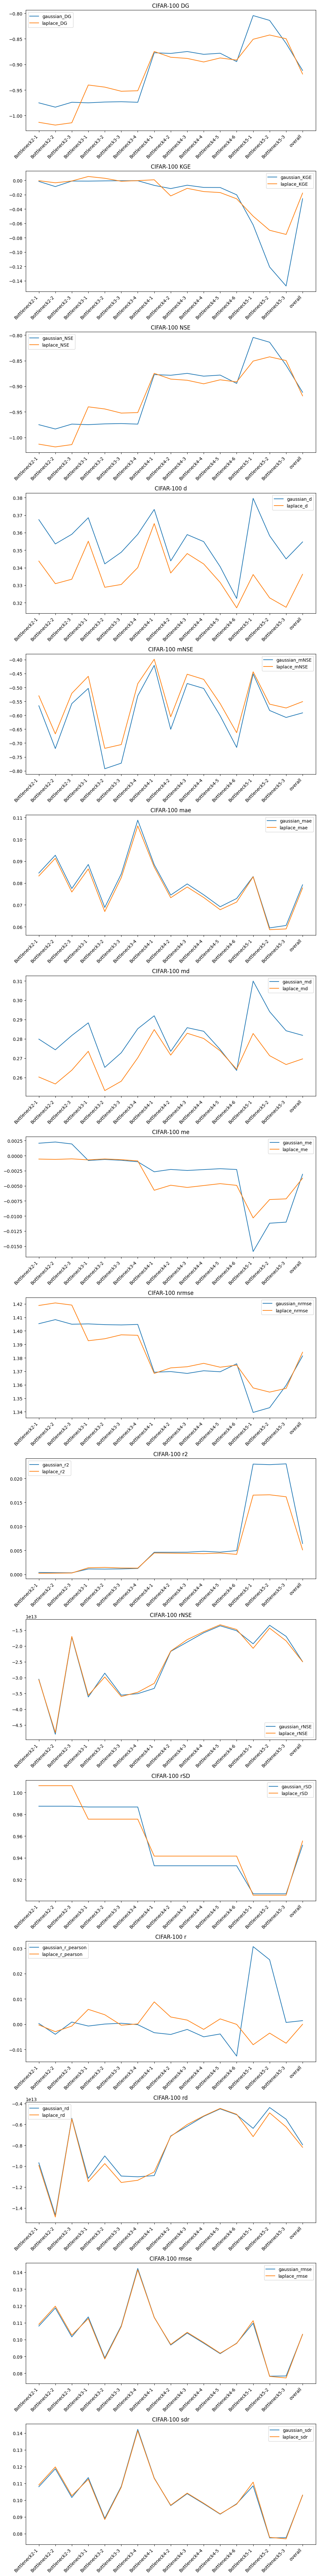

In [40]:
plot_metrics(sorted_df, dataset)